# sklearn应用之员工离职预测

In [1]:
#pandas, numpy, matplotlib, seaborn
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from scipy.stats import ttest_ind # T检验
from statsmodels.stats.weightstats import ztest # Z检验
from scipy.stats import chi2_contingency # 卡方检验
from scipy.stats import f_oneway # ANOVA(方差分析)
from math import fabs

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

In [83]:
train = pd.read_csv('../dataset/pfm_train.csv')
# df_test = pd.read_csv('../dataset/pfm_test.csv')

In [84]:
remove_list = []
for col in train.columns:
    n = len(train[col].unique())
    if n < 2:
        remove_list.append(col)
    elif n == len(train):
        remove_list.append(col)
        
train.drop(remove_list, axis=1, inplace=True)

# 目标变量
target_var = 'Attrition'

# 分类变量
cat_col = ['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole','PerformanceRating',
 'MaritalStatus',
 'OverTime']

# 数值变量
num_col = ['Age',
 'DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

# 有序变量
ord_col = ['Education',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance']

In [85]:
new_train = train.copy()

In [86]:
new_train['BusinessTravel'] = new_train['BusinessTravel'].map({'Non-Travel':1,
                                                               'Travel_Rarely':2,
                                                               'Travel_Frequently':3})

new_train['Department'] = new_train['Department'].map({'Human Resources':1,
                                                       'Sales':2,
                                                       'Research & Development':3})

new_train['Gender'] = new_train['Gender'].map({'Female':0, 'Male':1})
new_train['PerformanceRating'] = new_train['PerformanceRating']-2
new_train['MaritalStatus'] = new_train['MaritalStatus'].map({'Single':1,
                                                             'Married':2,
                                                             'Divorced':3})
new_train['OverTime'] = new_train['OverTime'].map({'No':1, 'Yes':1})

new_train['EducationField'] = new_train['EducationField'].map({'Life Sciences':1,
                                                               'Medical':2,
                                                               'Marketing':3,
                                                               'Technical Degree':4,
                                                               'Other':5,
                                                               'Human Resources':5})

new_train['JobRole'] = new_train['JobRole'].map({'Sales Executive':1,
                                                 'Research Scientist':2,
                                                 'Laboratory Technician':3,
                                                 'Manufacturing Director':4,
                                                 'Manager':4,
                                                 'Research Director':4,
                                                 'Healthcare Representative':1,
                                                 'Sales Representative':1,
                                                 'Human Resources':5})

In [87]:
new_train['TotalSatisfaction'] =  new_train[['EnvironmentSatisfaction',
                                            'JobInvolvement',
                                            'JobSatisfaction',
                                            'RelationshipSatisfaction',
                                            'WorkLifeBalance']].sum(axis=1)

In [88]:
new_train.loc[new_train['NumCompaniesWorked']==0, 'AverageWorkingYears'] = 0
new_train.loc[new_train['NumCompaniesWorked']>0, 'AverageWorkingYears'] = (new_train.loc[new_train['NumCompaniesWorked']>0,'TotalWorkingYears']\
                                                                         - new_train.loc[new_train['NumCompaniesWorked']>0,'YearsAtCompany'])\
                                                                         / new_train.loc[new_train['NumCompaniesWorked']>0,'NumCompaniesWorked']

In [89]:
def average_income(role_level):
    x, y = role_level
    crosstable = new_train.pivot_table(index='JobRole', columns='JobLevel', values='MonthlyIncome')
    return crosstable.loc[x, y]

new_train['Average_Income'] = new_train[['JobRole', 'JobLevel']].apply(average_income, axis=1)

In [90]:
def income_level(income):
    x, y = income
    if x < y:
        return 1
    else:
        return 0
new_train['Income_Level'] = new_train[['Average_Income', 'MonthlyIncome']].apply(income_level, axis=1)

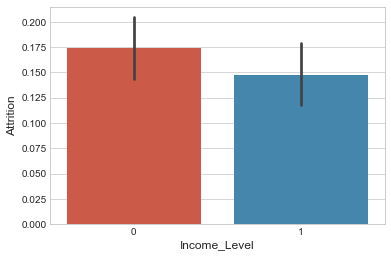

In [82]:
sns.barplot(x='Income_Level', y=target_var, data=new_train)

In [91]:
y = new_train[target_var]
X = new_train.drop([target_var], axis=1)

# X = pd.get_dummies(X, columns=['BusinessTravel', 'Department', 'MaritalStatus', 'EducationField', 'JobRole'])

In [67]:
num_col = [x for x in X.columns if x not in cat_col]

for col in num_col:
    if fabs(X[col].skew())>0.75:
        X[col] = np.log1p(X[col])

In [68]:
X = pd.get_dummies(X, columns=['BusinessTravel', 'Department', 'MaritalStatus', 'EducationField', 'JobRole'])

## 划分数据集

In [92]:
kfold = StratifiedKFold(n_splits=10, random_state=45)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)
print('训练集\'0\'的个数为：{}'.format(np.bincount(y_train)[0]))
print('训练集\'1\'的个数为：{}'.format(np.bincount(y_train)[1]))
print('验证集\'0\'的个数为：{}'.format(np.bincount(y_test)[0]))
print('验证集\'1\'的个数为：{}'.format(np.bincount(y_test)[1]))

训练集'0'的个数为：644
训练集'1'的个数为：126
验证集'0'的个数为：278
验证集'1'的个数为：52


In [71]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
for col in num_col:
    std_scaler.fit(X_train[col].values.reshape(-1,1))
    X_train[col]=std_scaler.transform(X_train[col].values.reshape(-1,1))
    X_test[col]=std_scaler.transform(X_test[col].values.reshape(-1,1))

## 特征工程
只对分类变量生成虚拟变量

In [95]:
label_enc = LabelEncoder()

for col in cat_col:
    if len(X_train[col].unique()) > 2:
        X_train = pd.get_dummies(X_train, columns=[col])
        X_test = pd.get_dummies(X_test, columns=[col])
    else:
        label_enc.fit(X_train[col].values.reshape(-1,1))
        X_train[col] = label_enc.transform(X_train[col])
        X_test[col] = label_enc.transform(X_test[col])

## 特征工程

In [96]:
for col in num_col:
    bins = [X[col].min()-1]
    bins.extend([X[col].min()+i*(X[col].max()-X[col].min())/5 for i in range(1, 6)])
    name = '{}_Bank'.format(col)
    X_train[name] = pd.cut(X_train[col], bins=bins, labels=[1,2,3,4,5])
    X_test[name] = pd.cut(X_test[col], bins=bins, labels=[1,2,3,4,5])
    print('{}, train:{}, test:{}'.format(col,len( X_train[name].unique()), len(X_test[name].unique())))


Age, train:5, test:5
DistanceFromHome, train:5, test:5
MonthlyIncome, train:5, test:5
NumCompaniesWorked, train:5, test:5
PercentSalaryHike, train:5, test:5
TotalWorkingYears, train:5, test:5
YearsAtCompany, train:5, test:5
YearsInCurrentRole, train:5, test:5
YearsSinceLastPromotion, train:5, test:5
YearsWithCurrManager, train:5, test:5


In [97]:
X_train = pd.get_dummies(X_train, columns=X_train.filter(regex='_Bank').columns.tolist())
X_test = pd.get_dummies(X_test, columns=X_test.filter(regex='_Bank').columns.tolist())

In [98]:
X_train.drop(num_col, axis=1, inplace=True)
X_test.drop(num_col, axis=1, inplace=True)

In [99]:
# 合并所有satisfaction的变量
X_train['TotalSatisfcation'] = X_train.filter(regex='Satisfaction').sum(axis=1)
X_test['TotalSatisfcation'] = X_test.filter(regex='Satisfaction').sum(axis=1)

## 分类器评估函数

In [59]:
# 分类器评估函数

def display_result(estimator, X_train, X_test, y_train, y_test, cv):
    print('\n===================== {} 测试结果 ====================='.format(estimator.__class__.__name__))
    # 交叉验证
    cv_result = cross_validate(estimator=estimator, cv=cv,
                               X=np.array(X_train), y=np.array(y_train))
    print('\n交叉验证结果')
    print('训练集： {:.4f}(+/-{:.4f})'.format(cv_result['train_score'].mean(), cv_result['train_score'].std()))
    print('验证集： {:.4f}(+/-{:.4f})'.format(cv_result['test_score'].mean(), cv_result['test_score'].std()))
    
    estimator.fit(np.array(X_train), np.array(y_train))
    train_pred = estimator.predict(np.array(X_train))
    train_score = accuracy_score(y_true=np.array(y_train), y_pred=train_pred)
    print('\n训练集得分: {:.4f}'.format(train_score))
    
    test_pred = estimator.predict(np.array(X_test))
    test_score = accuracy_score(y_true=np.array(y_test), y_pred=test_pred)
    print('测试集得分: {:.4f}'.format(test_score))
    
    print('\n验证报告')
    print(classification_report(y_pred=test_pred, y_true=np.array(y_test), labels=[1, 0]))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    # 绘制混合矩阵
    conf_mat = confusion_matrix(y_pred=test_pred, y_true=np.array(y_test))
    sns.heatmap(conf_mat, annot=True, ax=ax1, annot_kws={'fontsize':15}, fmt='d', cmap=plt.cm.Blues)
    
    # 绘制ROC曲线
    if hasattr(estimator, 'decision_function'):
        y_score = estimator.decision_function(np.array(X_test))
    else:
        y_score = estimator.predict_proba(np.array(X_test))[:, 1]
    fpr, tpr, _ = roc_curve(y_true=np.array(y_test), y_score=y_score)
    roc_score = roc_auc_score(np.array(y_test), y_score)
    ax2.plot(fpr, tpr)
    ax2.plot([0,1], [0,1], 'b--')
    ax2.set_title('{}, AUC={:.4f}'.format(estimator.__class__.__name__, roc_score))
    
    return estimator

## 用Logistic回归生成baseline


===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.8714(+/-0.0042)
验证集： 0.8520(+/-0.0247)

训练集得分: 0.8675
测试集得分: 0.8667

验证报告
             precision    recall  f1-score   support

          1       0.70      0.27      0.39        52
          0       0.88      0.98      0.93       278

avg / total       0.85      0.87      0.84       330



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

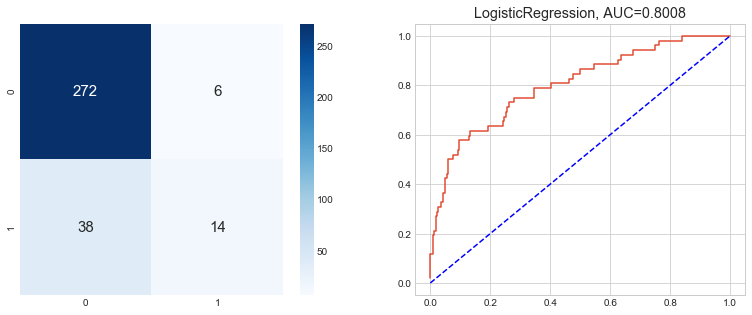

In [72]:
lr = LogisticRegression(random_state=45)
display_result(lr, X_train, X_test, y_train, y_test, kfold)

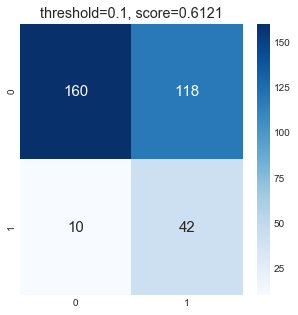

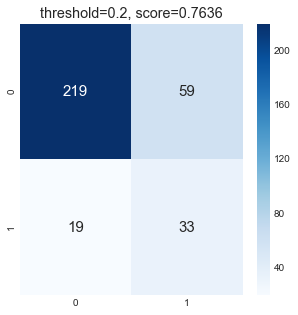

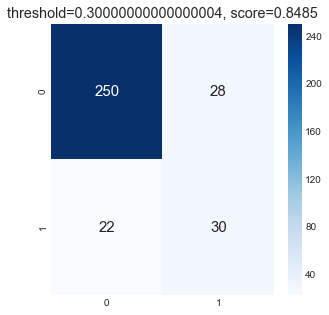

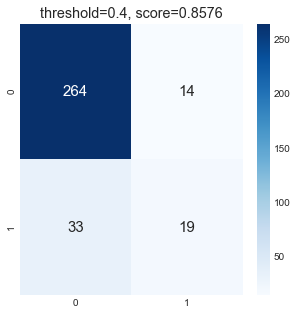

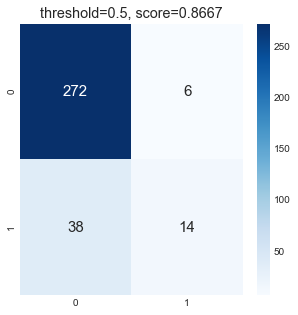

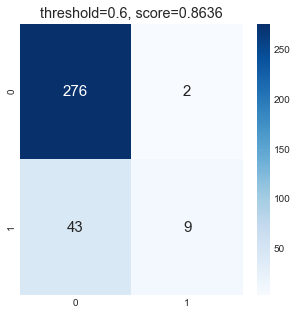

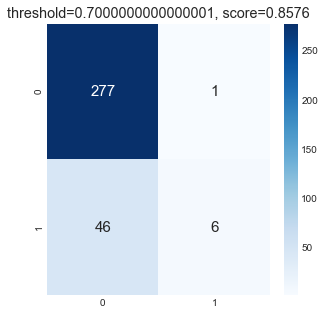

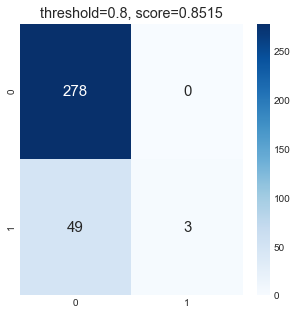

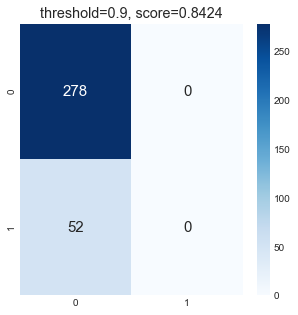

In [73]:
from sklearn.preprocessing import Binarizer

lr.fit(X_train, y_train)
y_proba = lr.predict_proba(X_test)
for threshold in np.linspace(.1, .9, 9):
    binarizer = Binarizer(threshold=threshold)
    y_pred = binarizer.fit_transform(y_proba[:, 1].reshape(-1,1))
    score = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_pred=y_pred, y_true=np.array(y_test))
    _ = plt.figure(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, annot_kws={'fontsize':15}, fmt='d', cmap=plt.cm.Blues)
    plt.title('threshold={}, score={:.4f}'.format(threshold, score))

## 过采样

In [74]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=45)
smote_x, smote_y = smote.fit_sample(X_train, y_train)
print('\'0\'的个数为：{}'.format(np.bincount(smote_y)[0]))
print('\'1\'的个数为：{}'.format(np.bincount(smote_y)[1]))

'0'的个数为：644
'1'的个数为：644



===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.7715(+/-0.0062)
验证集： 0.7502(+/-0.0413)

训练集得分: 0.7717
测试集得分: 0.7333

验证报告
             precision    recall  f1-score   support

          1       0.33      0.69      0.45        52
          0       0.93      0.74      0.82       278

avg / total       0.83      0.73      0.77       330



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

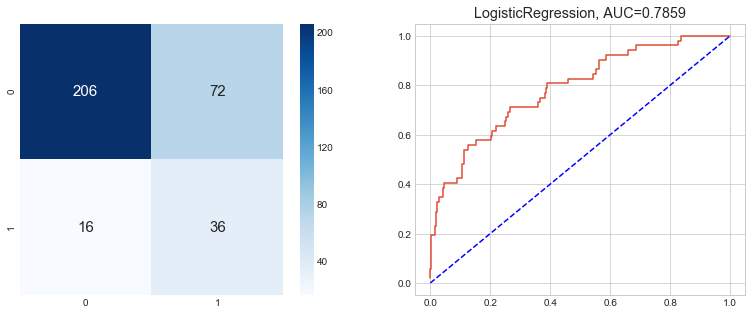

In [75]:
lr = LogisticRegression(random_state=45)
display_result(lr, smote_x, X_test, smote_y, y_test, kfold)

In [77]:
def tunning_params(model, params, kfold=kfold, X_train=smote_x,y_train=smote_y):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=kfold).fit(X_train, y_train)
    print('优化后模型:')
    print('最佳参数: %s' % str(grid_search.best_params_))
    print('最佳得分: %.4f' % grid_search.best_score_)
    model = model.set_params(**(grid_search.best_params_))
    return model

优化后模型:
最佳参数: {'C': 0.10000000000000001, 'penalty': 'l2'}
最佳得分: 0.7570

===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.7719(+/-0.0047)
验证集： 0.7572(+/-0.0302)

训练集得分: 0.7741
测试集得分: 0.7394

验证报告
             precision    recall  f1-score   support

          1       0.34      0.69      0.46        52
          0       0.93      0.75      0.83       278

avg / total       0.84      0.74      0.77       330



LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=45,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

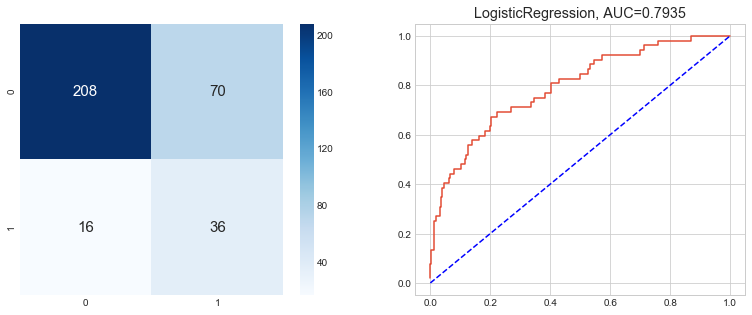

In [78]:
params = {'penalty':['l1', 'l2'],
          'C': np.logspace(-2, 2, 5)}
lr = tunning_params(lr, params, kfold, smote_x,smote_y)
display_result(lr, smote_x, X_test, smote_y, y_test, kfold)

## 生成新变量
### 连续变量加减乘除

In [97]:
n = len(num_col)
new_num = []
# 连续变量加
for x in range(n):
    for y in range(x, n):
        name = num_col[x] + '+' + num_col[y]
        new_num.append(name)
        X[name] = X[num_col[x]]+X[num_col[y]]
#         X_test[name] = X_test[num_col[x]]+X_test[num_col[y]]
# 连续变量减
for x in num_col:
    for y in num_col:
        if x != y:
            name = x + '-' + y
            new_num.append(name)
            X[name] = X[x]-X[y]
#             X_test[name] = X_test[x]-X_test[y]
            
# 连续变量乘
for x in range(n):
    for y in range(x,n):
        name = num_col[x] + '*' + num_col[y]
        new_num.append(name)
        X[name] = X[num_col[x]]*X[num_col[y]]
#         X_test[name] = X_test[num_col[x]]*X_test[num_col[y]]
# 连续变量除
for x in num_col:
    for y in num_col:
        if x != y:
            if df_train[y].isin([0]).sum() == 0:
                name = x + '/' + y
                new_num.append(name)
                X[name] = X[x]/X[y]
#                 X_test[name] = X_test[x]/X_test[y]
                
num_col += new_num

In [98]:
X.apply(lambda x: sum(x.isnull()))

Age                                          0
DistanceFromHome                             0
Education                                    0
EnvironmentSatisfaction                      0
JobInvolvement                               0
JobLevel                                     0
JobSatisfaction                              0
MonthlyIncome                                0
NumCompaniesWorked                           0
PercentSalaryHike                            0
PerformanceRating                            0
RelationshipSatisfaction                     0
StockOptionLevel                             0
TotalWorkingYears                            0
TrainingTimesLastYear                        0
WorkLifeBalance                              0
YearsAtCompany                               0
YearsInCurrentRole                           0
YearsSinceLastPromotion                      0
YearsWithCurrManager                         0
BusinessTravel_Non-Travel                    0
BusinessTrave

## 特征工程

## 划分数据集

In [99]:
y = df_train['Attrition'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)
print('训练集\'0\'的个数为：{}'.format(np.bincount(y_train)[0]))
print('训练集\'1\'的个数为：{}'.format(np.bincount(y_train)[1]))
print('验证集\'0\'的个数为：{}'.format(np.bincount(y_test)[0]))
print('验证集\'1\'的个数为：{}'.format(np.bincount(y_test)[1]))

训练集'0'的个数为：644
训练集'1'的个数为：126
验证集'0'的个数为：278
验证集'1'的个数为：52


In [100]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=45)
smote_x, smote_y = smote.fit_sample(X_train, y_train)

In [101]:
smote_x = pd.DataFrame(smote_x, columns=X_train.columns.tolist())

In [102]:
from sklearn.preprocessing import MinMaxScaler
std_scaler = StandardScaler()
for x in num_col:
    std_scaler.fit(smote_x[x].values.reshape(-1,1))
    smote_x[x] = std_scaler.transform(smote_x[x].values.reshape(-1,1))
    X_test[x] = std_scaler.transform(X_test[x].values.reshape(-1,1))

## 建立模型
### 建立朴素分类器
因为在数据集中，Attrition=0的比例大于Attrition=1的比例，所以在朴素分类器中，将所有的结果预测为0。

In [58]:
y_pred = np.zeros((len(X_test)))
score = accuracy_score(y_test, y_pred)
print(score.round(4))

0.8424


## 建立分类器评估函数

In [59]:
# 分类器评估函数
kfold = StratifiedKFold(n_splits=10, random_state=45)
def display_result(estimator, X_train, X_test, y_train, y_test, cv):
    print('\n===================== {} 测试结果 ====================='.format(estimator.__class__.__name__))
    # 交叉验证
    cv_result = cross_validate(estimator=estimator, cv=cv,
                               X=np.array(X_train), y=np.array(y_train))
    print('\n交叉验证结果')
    print('训练集： {:.4f}(+/-{:.4f})'.format(cv_result['train_score'].mean(), cv_result['train_score'].std()))
    print('验证集： {:.4f}(+/-{:.4f})'.format(cv_result['test_score'].mean(), cv_result['test_score'].std()))
    
    estimator.fit(np.array(X_train), np.array(y_train))
    train_pred = estimator.predict(np.array(X_train))
    train_score = accuracy_score(y_true=np.array(y_train), y_pred=train_pred)
    print('\n训练集得分: {:.4f}'.format(train_score))
    
    test_pred = estimator.predict(np.array(X_test))
    test_score = accuracy_score(y_true=np.array(y_test), y_pred=test_pred)
    print('测试集得分: {:.4f}'.format(test_score))
    
    print('\n验证报告')
    print(classification_report(y_pred=test_pred, y_true=np.array(y_test), labels=[1, 0]))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    # 绘制混合矩阵
    conf_mat = confusion_matrix(y_pred=test_pred, y_true=np.array(y_test))
    sns.heatmap(conf_mat, annot=True, ax=ax1, annot_kws={'fontsize':15}, fmt='d', cmap=plt.cm.Blues)
    
    # 绘制ROC曲线
    if hasattr(estimator, 'decision_function'):
        y_score = estimator.decision_function(np.array(X_test))
    else:
        y_score = estimator.predict_proba(np.array(X_test))[:, 1]
    fpr, tpr, _ = roc_curve(y_true=np.array(y_test), y_score=y_score)
    roc_score = roc_auc_score(np.array(y_test), y_score)
    ax2.plot(fpr, tpr)
    ax2.plot([0,1], [0,1], 'b--')
    ax2.set_title('{}, AUC={:.4f}'.format(estimator.__class__.__name__, roc_score))
    
    return estimator

### Logistic分类器


===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.8752(+/-0.0074)
验证集： 0.8201(+/-0.0412)

训练集得分: 0.8734
测试集得分: 0.7697

验证报告
             precision    recall  f1-score   support

          1       0.37      0.63      0.46        52
          0       0.92      0.79      0.85       278

avg / total       0.83      0.77      0.79       330



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

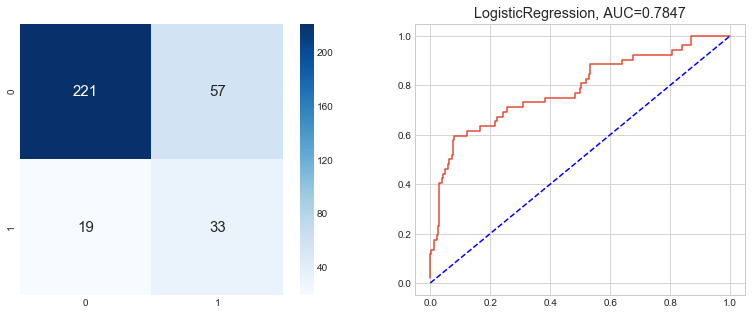

In [103]:
lr = LogisticRegression(random_state=45)
display_result(lr, smote_x, X_test, smote_y, y_test, kfold)

87.88%的准确率，结果似乎还可以，但是在朴素分类器中，准确率都有84%，Logistic回归的结果只是比猜测好一点。<br>
同时，在分类结果上，‘1’的精度远没有‘0’的精度高，说明很多‘1’被判断为‘0’，而‘0’基本分类正确。判断原因可能是因为数据不平衡造成。<br>
### 随机森林分类器


===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9808(+/-0.0048)
验证集： 0.8340(+/-0.0220)

训练集得分: 0.9714
测试集得分: 0.8485

验证报告
             precision    recall  f1-score   support

          1       0.56      0.17      0.26        52
          0       0.86      0.97      0.92       278

avg / total       0.82      0.85      0.81       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

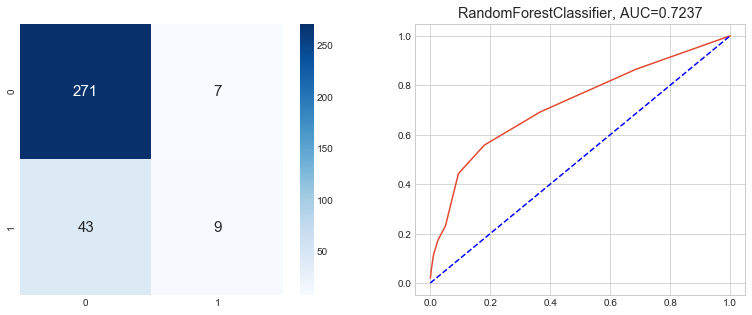

In [93]:
rf = RandomForestClassifier(random_state=45)
display_result(rf, X_train, X_test, y_train, y_test, kfold)

随机森林的准确率还不如Logistic分类器，分析结果，主要原因是'1'的精度和召回率都下降了。

### 分类器组测试结果

In [80]:
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=45)))
models.append(('LinearSVC', LinearSVC(random_state=45)))
models.append(('SGDClassifier', SGDClassifier(random_state=45)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state=45)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=45)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=45)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=45)))


===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.7715(+/-0.0062)
验证集： 0.7502(+/-0.0413)

训练集得分: 0.7717
测试集得分: 0.7333

验证报告
             precision    recall  f1-score   support

          1       0.33      0.69      0.45        52
          0       0.93      0.74      0.82       278

avg / total       0.83      0.73      0.77       330


===================== LinearSVC 测试结果 =====================

交叉验证结果
训练集： 0.7723(+/-0.0067)
验证集： 0.7479(+/-0.0422)

训练集得分: 0.7725
测试集得分: 0.7333

验证报告
             precision    recall  f1-score   support

          1       0.33      0.67      0.44        52
          0       0.92      0.74      0.82       278

avg / total       0.83      0.73      0.76       330


===================== SGDClassifier 测试结果 =====================

交叉验证结果
训练集： 0.6563(+/-0.0339)
验证集： 0.6477(+/-0.0638)

训练集得分: 0.7197
测试集得分: 0.7727

验证报告
             precision    recall  f1-score   support

          1       0.37      0.62      0.46        52
   

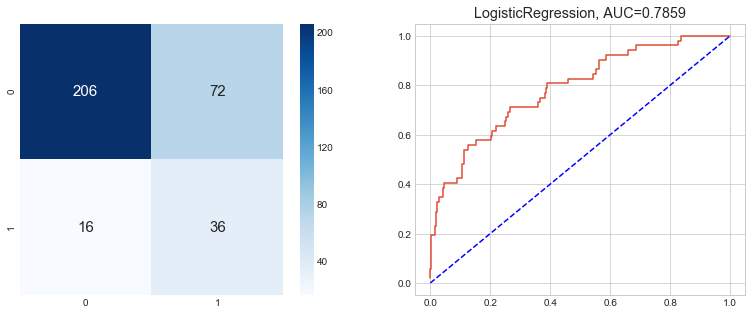

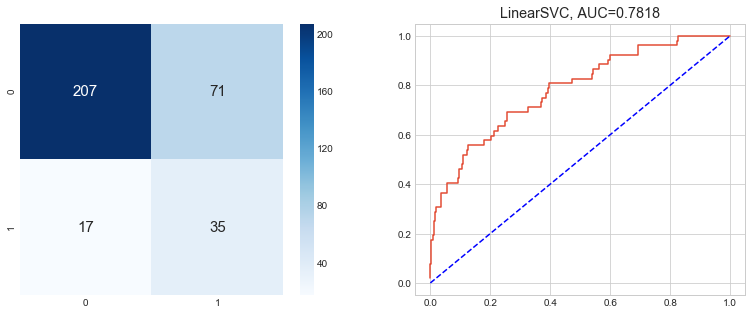

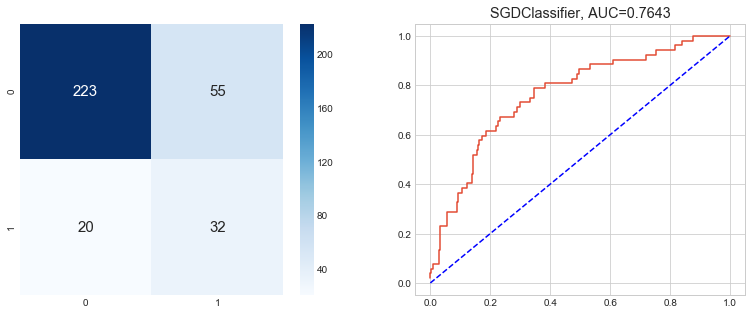

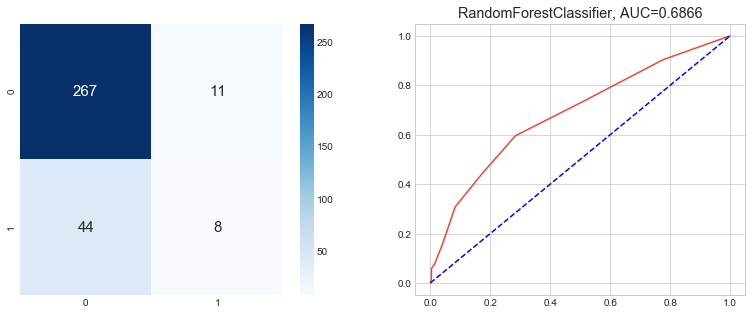

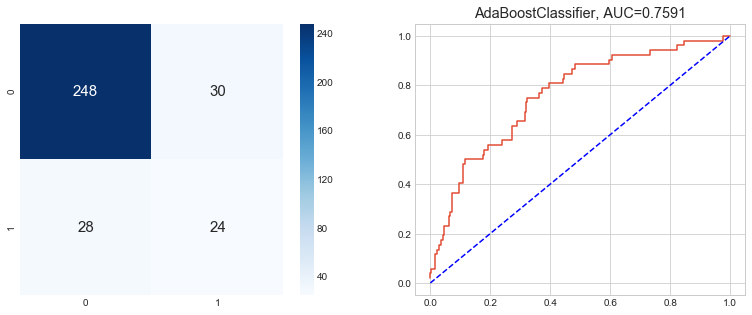

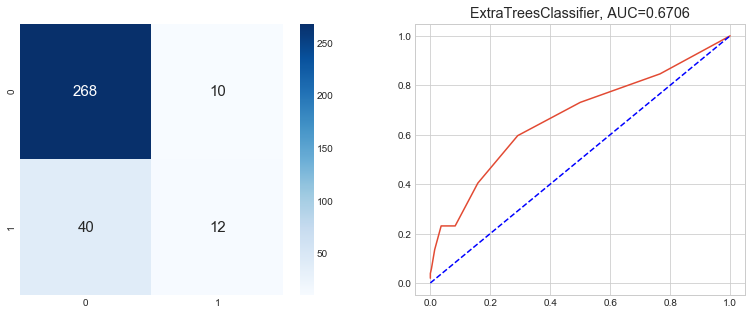

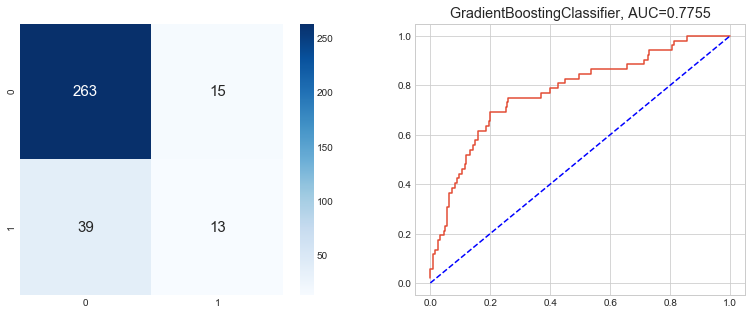

In [81]:
for name, clf in models:
    display_result(clf, smote_x, X_test, smote_y, y_test, kfold)

### 过采样


===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.7836(+/-0.0051)
验证集： 0.7741(+/-0.0315)

训练集得分: 0.7834
测试集得分: 0.7515

验证报告
             precision    recall  f1-score   support

          1       0.36      0.71      0.47        52
          0       0.93      0.76      0.84       278

avg / total       0.84      0.75      0.78       330



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

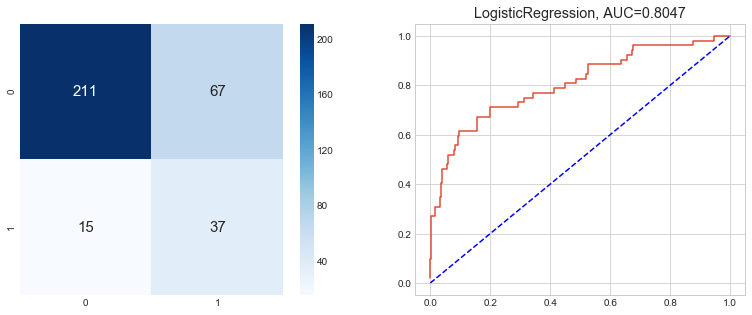

In [42]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=45)
smote_x, smote_y = smote.fit_sample(X_train, y_train)
 
display_result(lr, smote_x, X_test, smote_y, y_test, kfold)

使用过采样的方法，虽然'1'的召回率上升，即更多的‘1’被正确分类，但同时，‘1’的精度下降，即更多的‘0’被判为1。


===================== LogisticRegression 测试结果 =====================

交叉验证结果
训练集： 0.7836(+/-0.0051)
验证集： 0.7741(+/-0.0315)

训练集得分: 0.7834
测试集得分: 0.7515

验证报告
             precision    recall  f1-score   support

          1       0.36      0.71      0.47        52
          0       0.93      0.76      0.84       278

avg / total       0.84      0.75      0.78       330


===================== LinearSVC 测试结果 =====================

交叉验证结果
训练集： 0.5306(+/-0.0441)
验证集： 0.5304(+/-0.0537)

训练集得分: 0.5000
测试集得分: 0.1576

验证报告
             precision    recall  f1-score   support

          1       0.16      1.00      0.27        52
          0       0.00      0.00      0.00       278

avg / total       0.02      0.16      0.04       330


===================== SGDClassifier 测试结果 =====================

交叉验证结果
训练集： 0.5000(+/-0.0000)
验证集： 0.5000(+/-0.0000)

训练集得分: 0.5000
测试集得分: 0.8424

验证报告
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        52
   

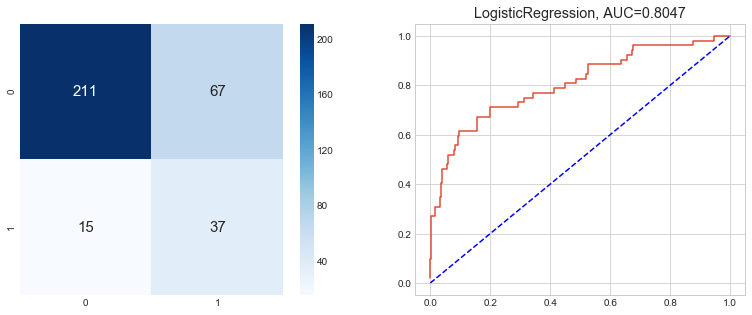

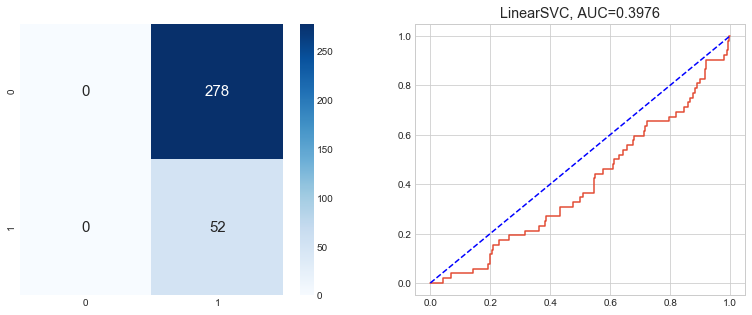

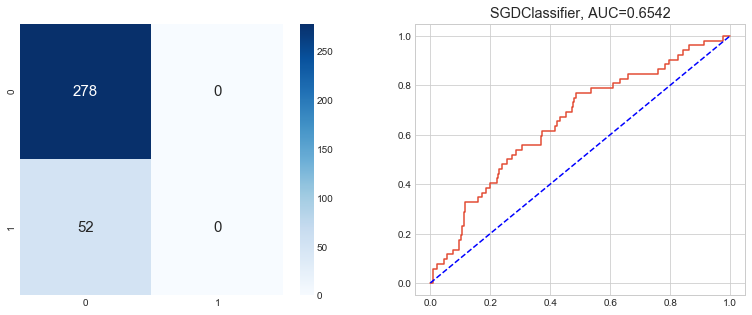

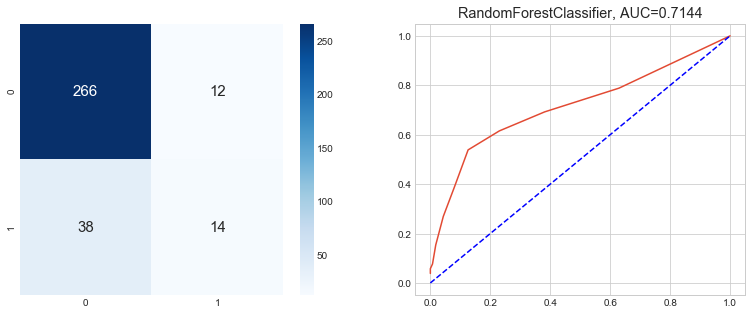

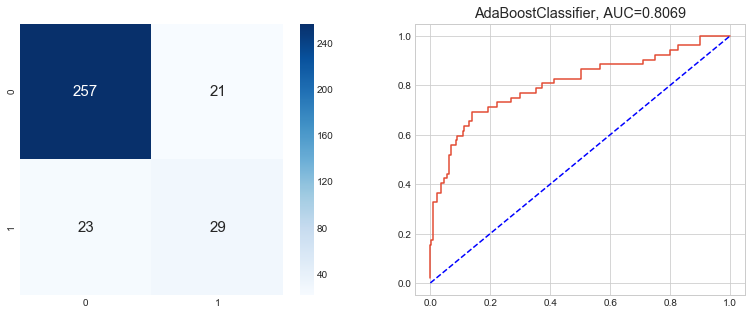

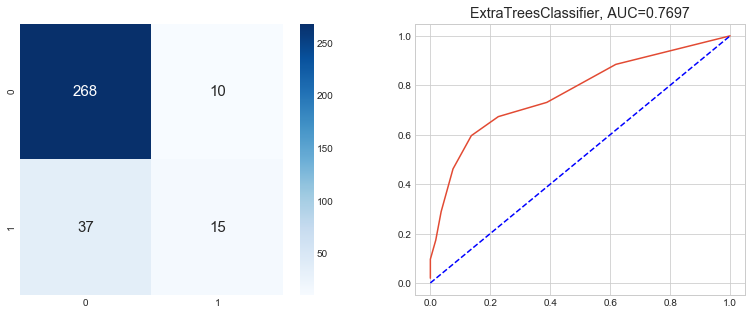

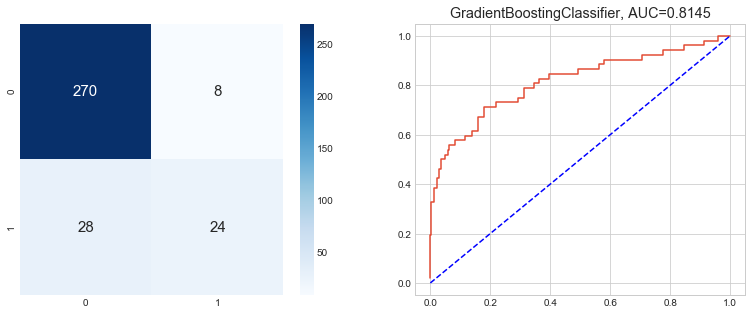

In [43]:
for name, clf in models:
    display_result(clf, smote_x, X_test, smote_y, y_test, kfold)

对训练集进行过采样处理后，除Logistic回归在‘1’的召回率上有提高外，其他线性分类器和朴素分类器的表现差不多。对于采用集成学习的分类器而言，虽然在准确度上没有提升，但是在‘1’的召回率上都有提升。

## 调参

In [46]:
def tunning_params(model, params, kfold=kfold, X_train=smote_x,y_train=smote_y):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=kfold).fit(X_train, y_train)
    print('优化后模型:')
    print('最佳参数: %s' % str(grid_search.best_params_))
    print('最佳得分: %.4f' % grid_search.best_score_)
    model = model.set_params(**(grid_search.best_params_))
    return model

### 随机森林调参

优化后模型:
最佳参数: {'n_estimators': 80}
最佳得分: 0.9270

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9999(+/-0.0003)
验证集： 0.9275(+/-0.1129)

训练集得分: 1.0000
测试集得分: 0.8848

验证报告
             precision    recall  f1-score   support

          1       0.89      0.31      0.46        52
          0       0.88      0.99      0.94       278

avg / total       0.89      0.88      0.86       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

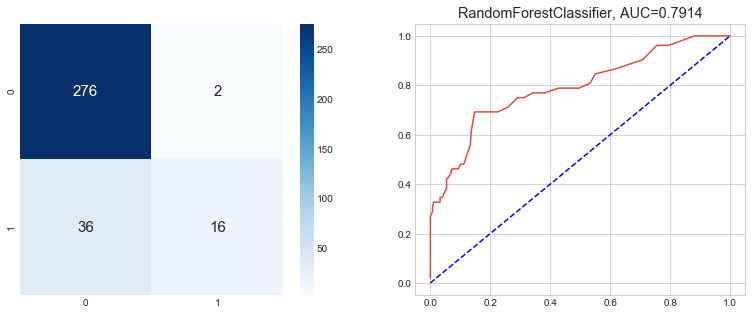

In [43]:
parameters = {
    'n_estimators': range(10, 110, 10)
}

rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'max_depth': 11}
最佳得分: 0.9247

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9998(+/-0.0003)
验证集： 0.9252(+/-0.1180)

训练集得分: 1.0000
测试集得分: 0.8818

验证报告
             precision    recall  f1-score   support

          1       0.84      0.31      0.45        52
          0       0.88      0.99      0.93       278

avg / total       0.88      0.88      0.86       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

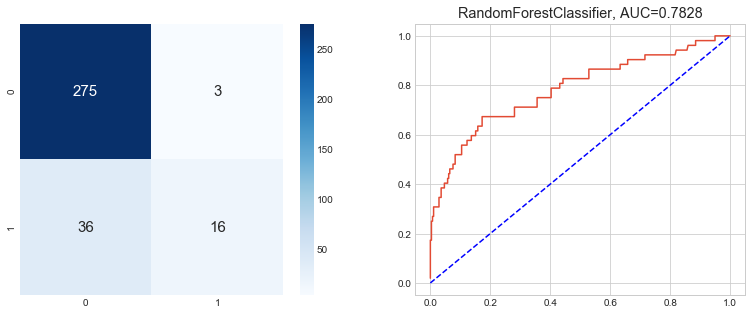

In [45]:
parameters = {'max_depth':range(3,14,2)
             }
rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'max_depth': None}
最佳得分: 0.9270

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9999(+/-0.0003)
验证集： 0.9275(+/-0.1129)

训练集得分: 1.0000
测试集得分: 0.8848

验证报告
             precision    recall  f1-score   support

          1       0.89      0.31      0.46        52
          0       0.88      0.99      0.94       278

avg / total       0.89      0.88      0.86       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

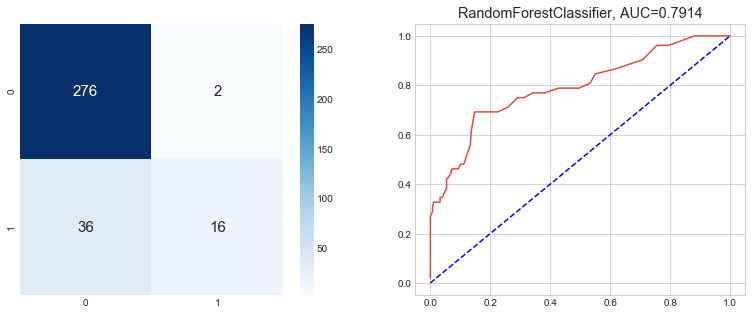

In [47]:
parameters = {'max_depth':[10, 11, 12, None]
             }
rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'min_samples_leaf': 2, 'min_samples_split': 5}
最佳得分: 0.9286

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9892(+/-0.0024)
验证集： 0.9291(+/-0.1113)

训练集得分: 0.9876
测试集得分: 0.8697

验证报告
             precision    recall  f1-score   support

          1       0.68      0.33      0.44        52
          0       0.89      0.97      0.93       278

avg / total       0.85      0.87      0.85       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

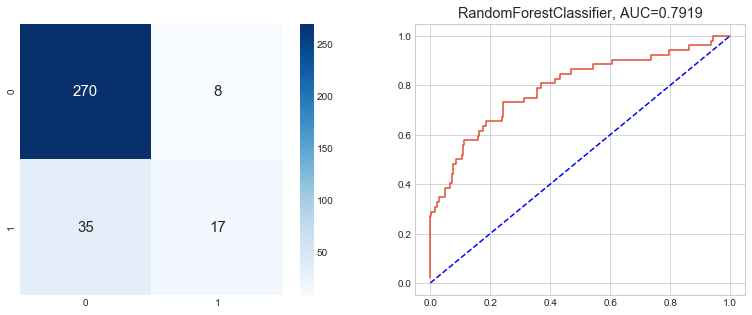

In [48]:
parameters = {'min_samples_split':range(2,20), 'min_samples_leaf':range(1,10)}
rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'min_samples_leaf': 2, 'min_samples_split': 5}
最佳得分: 0.9286

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9892(+/-0.0024)
验证集： 0.9291(+/-0.1113)

训练集得分: 0.9876
测试集得分: 0.8697

验证报告
             precision    recall  f1-score   support

          1       0.68      0.33      0.44        52
          0       0.89      0.97      0.93       278

avg / total       0.85      0.87      0.85       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

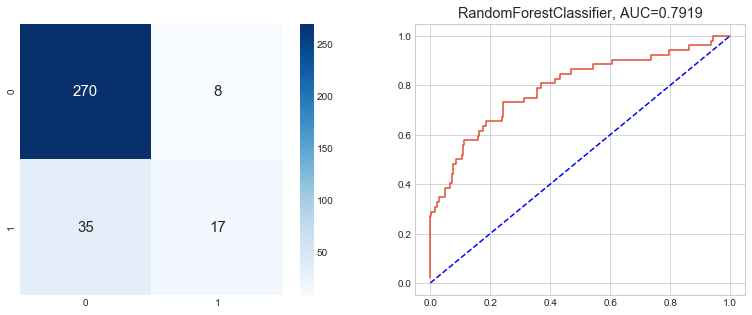

In [51]:
parameters = {'min_samples_split':[4,5,6], 'min_samples_leaf':[1,2,3]}
rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'max_features': 6}
最佳得分: 0.9286

===================== RandomForestClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9892(+/-0.0024)
验证集： 0.9291(+/-0.1113)

训练集得分: 0.9876
测试集得分: 0.8697

验证报告
             precision    recall  f1-score   support

          1       0.68      0.33      0.44        52
          0       0.89      0.97      0.93       278

avg / total       0.85      0.87      0.85       330



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=45, verbose=0, warm_start=False)

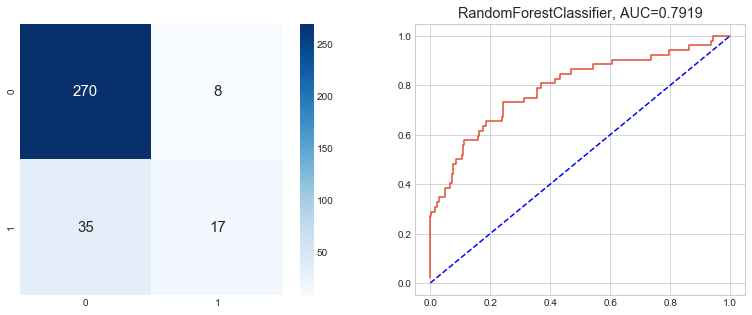

In [56]:
parameters = {
    'max_features': range(3, 9)
}
rf = tunning_params(rf, parameters)
display_result(rf, smote_x, X_test, smote_y, y_test, kfold)

In [79]:
def display_rfe(estimator, X_train, X_test, y_train, y_test, cv):
    print('\n===================== {}个特征 ====================='.format(i))
    # 交叉验证
    cv_result = cross_validate(estimator=estimator, cv=cv,
                               X=np.array(X_train), y=np.array(y_train))
    print('\n交叉验证结果')
    print('训练集： {:.4f}(+/-{:.4f})'.format(cv_result['train_score'].mean(), cv_result['train_score'].std()))
    print('验证集： {:.4f}(+/-{:.4f})'.format(cv_result['test_score'].mean(), cv_result['test_score'].std()))
    
    estimator.fit(np.array(X_train), np.array(y_train))
    train_pred = estimator.predict(np.array(X_train))
    train_score = accuracy_score(y_true=np.array(y_train), y_pred=train_pred)
    print('\n训练集得分: {:.4f}'.format(train_score))
    
    test_pred = estimator.predict(np.array(X_test))
    test_score = accuracy_score(y_true=np.array(y_test), y_pred=test_pred)
    print('测试集得分: {:.4f}'.format(test_score))
    print(estimator.get_support())
    return train_score, test_score


===================== 1个特征 =====================

交叉验证结果
训练集： 0.9482(+/-0.0044)
验证集： 0.6088(+/-0.0331)

训练集得分: 0.9449
测试集得分: 0.6061
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]

===================== 2个特征 =====================

交叉验证结果
训练集： 0.9756(+/-0.0085)
验证集： 0.7636(+/-0.0828)

训练集得分: 0.9674
测试集得分: 0.7636
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True]

===================== 3个特征 =====================

交叉验证结果
训练集： 0.9836(+/-0.0047)
验证集： 0.8396(+/-0.0827)

训练集得分: 0.9798
测试集得分: 0.8030
[False False Fa


训练集得分: 0.9946
测试集得分: 0.8455
[ True  True False  True  True  True  True  True  True  True False False
  True  True  True  True  True  True False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True]

===================== 21个特征 =====================

交叉验证结果
训练集： 0.9938(+/-0.0011)
验证集： 0.9019(+/-0.1219)

训练集得分: 0.9946
测试集得分: 0.8636
[ True  True False  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True]

===================== 22个特征 =====================

交叉验证结果
训练集： 0.9934(+/-0.0016)
验证集： 0.9042(+/-0.1042)

训练集得分: 0.9938
测试集得分: 0.8455
[ True  True False  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True False  


交叉验证结果
训练集： 0.9944(+/-0.0018)
验证集： 0.9004(+/-0.1208)

训练集得分: 0.9938
测试集得分: 0.8606
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True False
  True  True False  True  True  True  True  True  True  True  True False
  True False False False  True False  True  True  True  True  True  True]

===================== 41个特征 =====================

交叉验证结果
训练集： 0.9950(+/-0.0016)
验证集： 0.9074(+/-0.1149)

训练集得分: 0.9984
测试集得分: 0.8758
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True False
  True  True False  True  True  True  True  True  True  True  True False
  True  True False False  True False  True  True  True  True  True  True]

===================== 42个特征 =====================

交叉验证结果
训练集： 0.9948(+/-0.0022)
验证集： 0.9059(+/-0.1303)

训练集得分: 0.9977
测试集得分: 0.8455
[ True  True  True  True  True  True  True  True  True  True  T

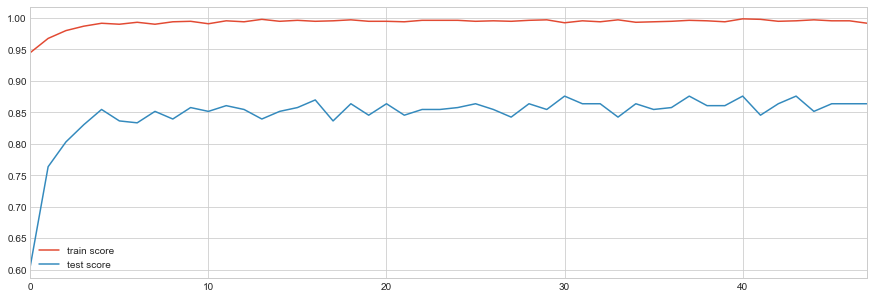

In [80]:
rfe_result = pd.DataFrame(columns=['train score', 'test score'])
for i in range(1, len(X_train.columns)+1):
    rfe = RFE(estimator=RandomForestClassifier(random_state=45), n_features_to_select=i)
    train_score, test_score = display_rfe(rfe, smote_x, X_test, smote_y, y_test, kfold)
    rfe_result.loc[len(rfe_result)] = [train_score, test_score]
rfe_result.plot(figsize=(15,5))

In [86]:
X_train.columns

Index(['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'J

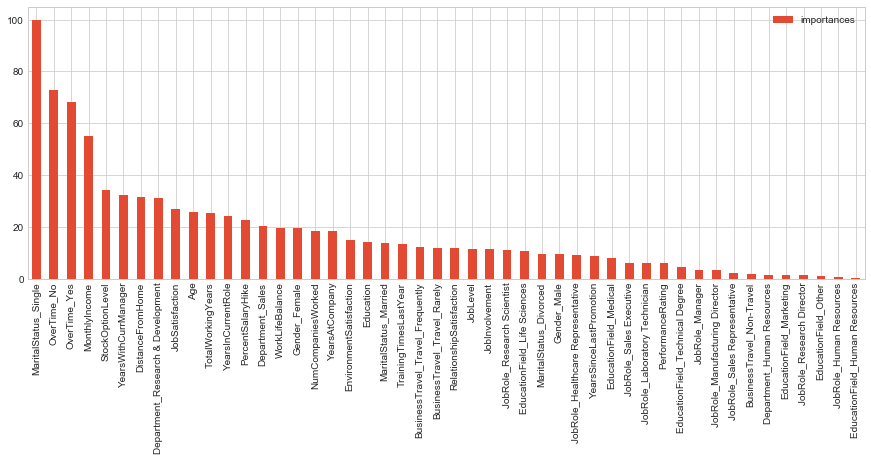

In [85]:
rf = RandomForestClassifier(random_state=45)
rf.fit(smote_x, smote_y)
feature_importances = pd.DataFrame({'importances':rf.feature_importances_},
                                   index=X_train.columns)\
                                   .sort_values(by='importances', ascending=False)
feature_importances = feature_importances / feature_importances.max() * 100
_ = feature_importances.plot(kind='bar', figsize=(15,5))

### Xgboos调参


===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 1.0000(+/-0.0000)
验证集： 0.9090(+/-0.1241)

训练集得分: 1.0000
测试集得分: 0.8818

验证报告
             precision    recall  f1-score   support

          1       0.72      0.40      0.52        52
          0       0.90      0.97      0.93       278

avg / total       0.87      0.88      0.87       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

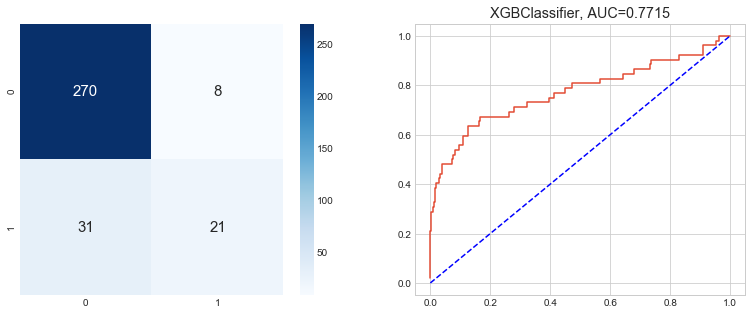

In [44]:
gbm = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=45)

display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'n_estimators': 200}
最佳得分: 0.9138

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 1.0000(+/-0.0000)
验证集： 0.9144(+/-0.1211)

训练集得分: 1.0000
测试集得分: 0.8879

验证报告
             precision    recall  f1-score   support

          1       0.74      0.44      0.55        52
          0       0.90      0.97      0.94       278

avg / total       0.88      0.89      0.88       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

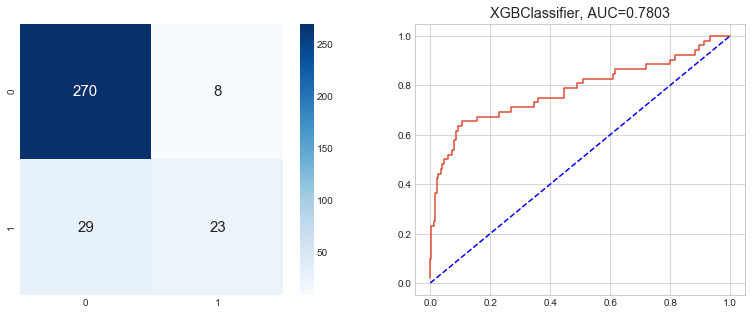

In [47]:
parameters = {'n_estimators': [100,200,500,1000,1500]}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'n_estimators': 200}
最佳得分: 0.9138

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 1.0000(+/-0.0000)
验证集： 0.9144(+/-0.1211)

训练集得分: 1.0000
测试集得分: 0.8879

验证报告
             precision    recall  f1-score   support

          1       0.74      0.44      0.55        52
          0       0.90      0.97      0.94       278

avg / total       0.88      0.89      0.88       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

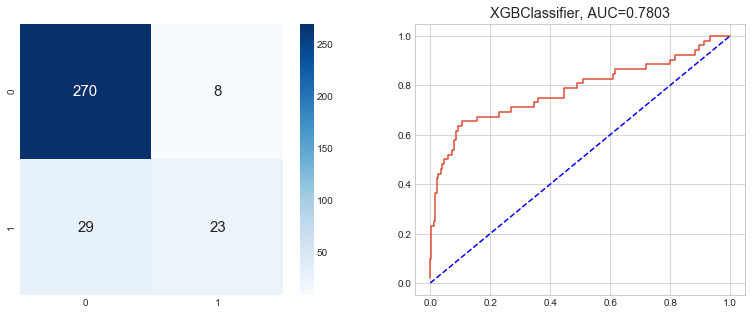

In [48]:
parameters = {'n_estimators': [150, 200, 250]}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'max_depth': 3, 'min_child_weight': 1}
最佳得分: 0.9138

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9795(+/-0.0059)
验证集： 0.9144(+/-0.1179)

训练集得分: 0.9752
测试集得分: 0.8727

验证报告
             precision    recall  f1-score   support

          1       0.63      0.46      0.53        52
          0       0.90      0.95      0.93       278

avg / total       0.86      0.87      0.86       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

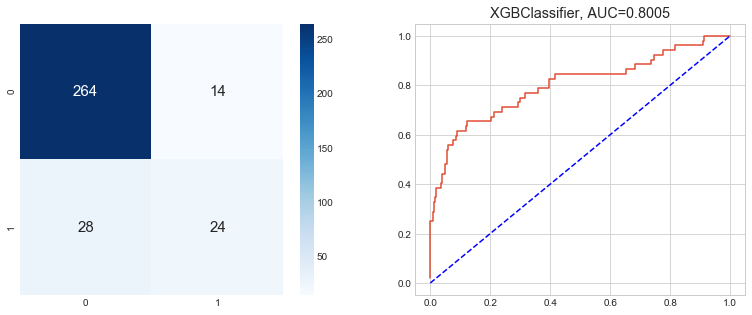

In [49]:
parameters = {
 'max_depth':range(1,15,2),
 'min_child_weight':range(1,6,2)
}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'max_depth': 7, 'min_child_weight': 1}
最佳得分: 0.9247

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9979(+/-0.0008)
验证集： 0.9252(+/-0.1197)

训练集得分: 0.9992
测试集得分: 0.8758

验证报告
             precision    recall  f1-score   support

          1       0.72      0.35      0.47        52
          0       0.89      0.97      0.93       278

avg / total       0.86      0.88      0.86       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=4, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

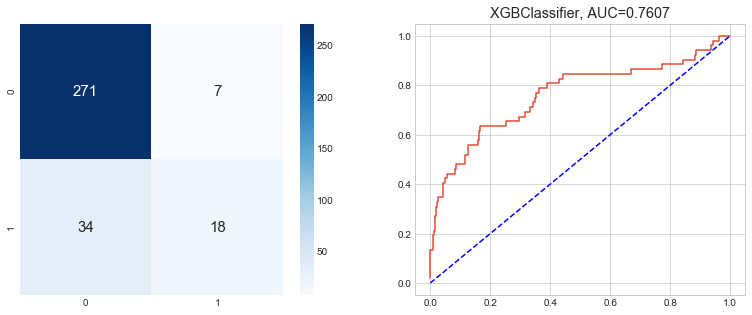

In [66]:
parameters = {
 'max_depth':[6,7,8],
 'min_child_weight':[1,2]
}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'gamma': 0.0}
最佳得分: 0.9247

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9979(+/-0.0008)
验证集： 0.9252(+/-0.1197)

训练集得分: 0.9992
测试集得分: 0.8758

验证报告
             precision    recall  f1-score   support

          1       0.72      0.35      0.47        52
          0       0.89      0.97      0.93       278

avg / total       0.86      0.88      0.86       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=4, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=45, silent=True, subsample=0.8)

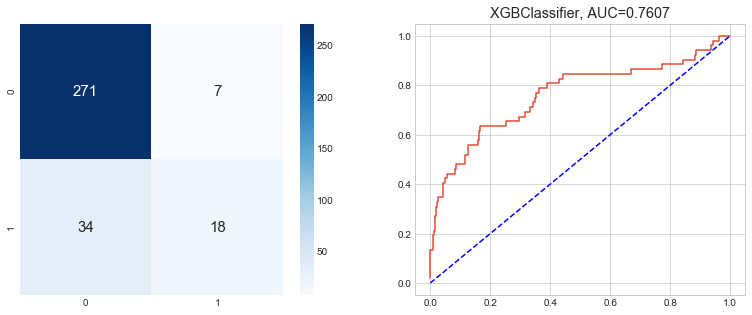

In [67]:
parameters = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'colsample_bytree': 0.8, 'subsample': 0.7}
最佳得分: 0.9286

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9949(+/-0.0007)
验证集： 0.9291(+/-0.1117)

训练集得分: 0.9969
测试集得分: 0.8758

验证报告
             precision    recall  f1-score   support

          1       0.72      0.35      0.47        52
          0       0.89      0.97      0.93       278

avg / total       0.86      0.88      0.86       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=4, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=45, silent=True, subsample=0.7)

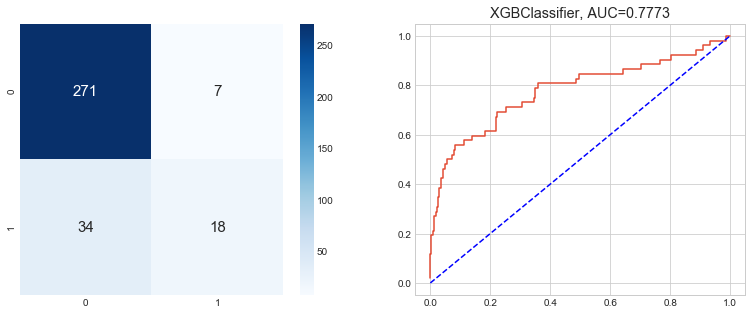

In [68]:
parameters = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)

优化后模型:
最佳参数: {'reg_alpha': 0, 'reg_lambda': 1}
最佳得分: 0.9286

===================== XGBClassifier 测试结果 =====================

交叉验证结果
训练集： 0.9949(+/-0.0007)
验证集： 0.9291(+/-0.1117)

训练集得分: 0.9969
测试集得分: 0.8758

验证报告
             precision    recall  f1-score   support

          1       0.72      0.35      0.47        52
          0       0.89      0.97      0.93       278

avg / total       0.86      0.88      0.86       330



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=4, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=45, silent=True, subsample=0.7)

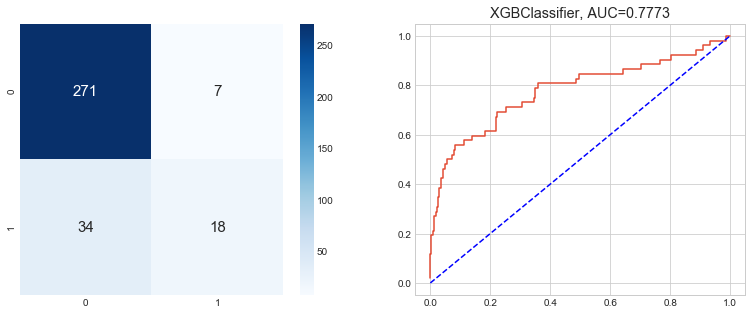

In [69]:
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100], 'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gbm = tunning_params(gbm, parameters)
display_result(gbm, smote_x, X_test, smote_y, y_test, kfold)


交叉验证结果
训练集： 0.7958(+/-0.0061)
验证集： 0.7780(+/-0.0266)

训练集得分: 0.7919
测试集得分: 0.7576

验证报告
             precision    recall  f1-score   support

          1       0.35      0.65      0.46        52
          0       0.92      0.78      0.84       278

avg / total       0.83      0.76      0.78       330



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

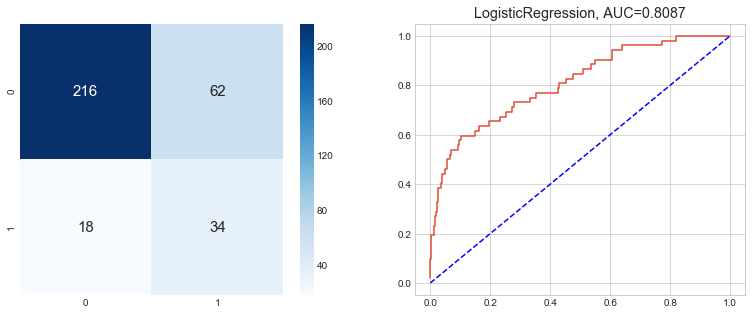

In [202]:
new_train = X_train.copy()
new_test = X_test.copy()


new_train['Age_Bank'] = pd.cut(new_train['Age'], bins=[17, 24, 54, 100], labels=['Young', 'Middle', 'Old'])
new_test['Age_Bank'] = pd.cut(new_test['Age'], bins=[17, 24, 54, 100], labels=['Young', 'Middle', 'Old'])
# new_train.drop(['NumCompaniesWorked', 'PercentSalaryHike', 'Education',
#        'PerformanceRating', 'RelationshipSatisfaction',
#        'TrainingTimesLastYear', 'WorkLifeBalance'], axis=1, inplace=True)
# new_test.drop(['NumCompaniesWorked', 'PercentSalaryHike', 'Education',
#        'PerformanceRating', 'RelationshipSatisfaction',
#        'TrainingTimesLastYear', 'WorkLifeBalance'], axis=1, inplace=True)

new_train['TotlaSatisfaction'] = new_train.filter(regex='Satisfaction|JobInvolvement|WorkLifeBalance')\
                                          .sum(axis=1)
new_test['TotlaSatisfaction'] = new_test.filter(regex='Satisfaction|JobInvolvement|WorkLifeBalance')\
                                          .sum(axis=1)

new_train = pd.get_dummies(new_train, columns=['Age_Bank'])
new_test = pd.get_dummies(new_test, columns=['Age_Bank'])



随机森林的结果比Logistic回归的结果更差，和朴素分类器的结果差不多。
### 特征重要性

In [69]:
feature_importances.index.tolist()

['MonthlyIncome',
 'Age',
 'TotlaSatisfaction',
 'TotalWorkingYears',
 'DistanceFromHome',
 'YearsAtCompany',
 'YearsWithCurrManager',
 'OverTime_Yes',
 'OverTime_No',
 'PercentSalaryHike',
 'YearsInCurrentRole',
 'StockOptionLevel',
 'NumCompaniesWorked',
 'JobSatisfaction',
 'WorkLifeBalance',
 'TrainingTimesLastYear',
 'EnvironmentSatisfaction',
 'JobLevel',
 'YearsSinceLastPromotion',
 'RelationshipSatisfaction',
 'Education',
 'JobInvolvement',
 'MaritalStatus_Single',
 'BusinessTravel_Travel_Frequently',
 'EducationField_Medical',
 'MaritalStatus_Married',
 'Age_Bank_Young',
 'Gender_Male',
 'Gender_Female',
 'EducationField_Life Sciences',
 'BusinessTravel_Travel_Rarely',
 'EducationField_Technical Degree',
 'Age_Bank_Middle',
 'Department_Sales',
 'JobRole_Laboratory Technician',
 'Department_Research & Development',
 'EducationField_Marketing',
 'MaritalStatus_Divorced',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'PerformanceRa

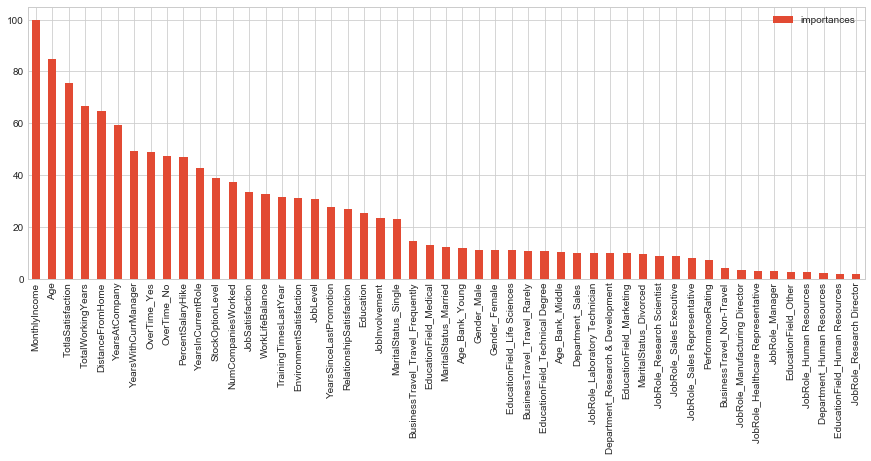

In [67]:
feature_importances = pd.DataFrame({'importances':rf.feature_importances_},
                                   index=new_train.columns)\
                                   .sort_values(by='importances', ascending=False)
feature_importances = feature_importances / feature_importances.max() * 100
_ = feature_importances.plot(kind='bar', figsize=(15,5))

In [ ]:
from scipy.stats import levene
for x in num_col:
    s1 = df_train.loc[df_train['Attrition']==1, x]
    s2 = df_train.loc[df_train['Attrition']==0, x]
    s, p = levene(s1, s2)
    if p < 0.05:
        print('%s方差不齐'%x)

In [ ]:
data = df_train.copy()
data[num_col] = data[num_col].apply(lambda x: np.log1p(x))
from scipy.stats import levene, boxcox
for x in num_col:
    values, lam = boxcox(data[x].values+1)
    data[x] = values
    s1 = data.loc[data['Attrition']==1, x]
    s2 = data.loc[data['Attrition']==0, x]
    s, p = levene(s1, s2)
    if p < 0.05:
        print('%s方差不齐'%x)

## 变量间的关系
总的来说，特征变量包括连续变量和分类变量。
* 连续变量间使用person相关系数判断两者之间是否有关联
* 分类变量间使用卡方检验判断两者之间是否有关联
* 连续变量和分类变量间
    * 如果分类变量包含两个特征值，使用Z检验或T检验
    * 如果分类变量包含两个以上的特征值，使用ANOVA方法

**在特征变量和目标变量间，需要两者存在关联，但是对于特征变量之间，需要他们不存在关联**。

In [ ]:
all_features = num_col+ord_col+cat_col
n = len(all_features)
result = pd.DataFrame(columns=['VS', 'value', 'True/False'])
for x in range(n):
    for y in range(n):
        if x >= y:
            continue
        vs = '{}<-->{}'.format(all_features[x], all_features[y])
        if all_features[x] in num_col and all_features[y] in num_col:
            corr = df_train[all_features[x]].corr(df_train[all_features[y]]).round(4)
            result.loc[len(result)] = [vs, corr, fabs(corr)>0.65]
        elif all_features[x] in num_col and all_features[y] != num_col:
            p = calc_p_value(df_train, all_features[x], all_features[y])
            result.loc[len(result)] = [vs, p, p<0.05]
        else:
            p = get_chi2_value(df_train, all_features[x], all_features[y])
            result.loc[len(result)] = [vs, p, p<0.05]

In [ ]:
result[result['True/False']==True]

In [ ]:
sns.pairplot(data=df_train[num_col+[target_var]], hue='Attrition')

对照上面的两张图，可以看出：
1. 和时间有关的特征，基本呈现一种正相关的关系。其中相关系数比较大的有：**Age和TotalWorkingYeas**，**TotalWorkingYears和YearsAtCompany**， **YearsAtCompnay和YearsInCurrRole、YearsWithCurrManager**；
2. **MonthlyIncome和TotalWorkingYears**的相关系数比较大；
3. **PercentSalaryHike**和其他变量都没有关系
从上面的图上还可以看出，有些特征分布的非常广，存在长尾，比如MonthlyIncome。

In [ ]:
# 检查每个连续变量的偏度
for col in num_col:
    print('{}------{:.4f}'.format(col, df_train[col].skew()))

MonthlyIncome,YearsAtCompany和YearsSinceLastPromotion的偏度还是非常大。考虑到有些连续特征的特征值可能为0，比如YearAtCompany，如果进行对数变换，某些取值就会为NA，因此采用开平方转换。

In [ ]:
sqrt_num_col = []
for col in num_col:
    name = col + '_sqrt'
    sqrt_num_col.append(name)
    df_train[name] = np.sqrt(df_train[col])
    print('{}------{:.4f}'.format(name, df_train[name].skew()))
sns.pairplot(data=df_train[sqrt_num_col+[target_var]], hue='Attrition')

In [ ]:
sns.heatmap(df_train[sqrt_num_col].corr(), annot=True)

### 分类变量分析

In [ ]:
for col in cat_col:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.countplot(x=col, data=df_train, ax=ax1)
    sns.barplot(x=col, y=target_var, data=df_train, ax=ax2)
    ax1.set_title('Frequency')
    ax2.set_title('Attrition')

从上面的图可以看出，有些特征在样本中所在的比例非常小，比如在DepartMent和EducationField中，HumanResource在样本中所在的比例非常小，在特征处理中，可以考虑将这类特征值与其他特征值合并。

在分类变量中，有Department，EducationField，我觉得这些变量似乎存在关系，比如学习human resource的不太可能去从事research的工作。用卡方检验检查这些变量之间的关系。

In [ ]:
contingency_table = df_train.pivot_table(index='Department', columns='EducationField', values='sum', aggfunc=sum).fillna(0)
print(stats.chi2_contingency(contingency_table))
contingency_table.plot(kind='bar', figsize=(15,5), rot=0)

零假设是Department和EducationField相互独立，显著性水平是0.05。计算得到的p值远小于0.05，所以拒绝零假设，即两个变量之间不独立。<br>
从图中也可以看出，学习human resource的员工，全部在human resource部门，学习life sciences和medical的大多从事research的工作，有些从事的是human resource工作。学习marketing几乎全在sales部门。<br>
同样用卡方检验，分析其他变量之间的关系，直接筛选除P值小于0.05的变量组。

In [ ]:
for x in cat_col:
    for y in cat_col:
        if x != y:
            contingency_table = df_train.pivot_table(index=x, columns=y, values='sum', aggfunc=sum).fillna(0)
            _, p, _, _ = stats.chi2_contingency(contingency_table)
            if p <= 0.05:
                print('{}<----->{}, pvalue={:.4f}'.format(x, y, p))

从上面的结果可以看出:
1. Department, EducationField, JobRole三者之间不独立
2. EducationField与MaritalStatus不独立

所以，可以在分类变量中删除EducationField和JobRole。

### 有序变量分析

In [ ]:
for col in ord_col:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.countplot(x=col, data=df_train, ax=ax1)
    sns.barplot(x=col, y=target_var, data=df_train, ax=ax2)
    ax1.set_title('Frequency')
    ax2.set_title('Attrition')

同样，对于有序变量来说，部分样本所在比例很低，可以考虑将它们和其他变量合并。

对有序变量进行卡方检验。

In [ ]:
for x in ord_col:
    for y in ord_col:
        if x != y:
            contingency_table = df_train.pivot_table(index=x, columns=y, values='sum', aggfunc=sum).fillna(0)
            _, p, _, _ = stats.chi2_contingency(contingency_table)
            if p<=0.05:
                print('{}<----->{}, pvalue={:.4f}'.format(x, y, p))

根据卡方检验的结果，可以得到结论：
1. Education，JobLevel，StockOptionLevel三者之间存在关联关系
2. 环境满意度和工作投入度不独立

In [ ]:
for x in ord_col+cat_col:
    for y in ord_col+cat_col:
        if x != y:
            contingency_table = df_train.pivot_table(index=x, columns=y, values='sum', aggfunc=sum).fillna(0)
            _, p, _, _ = stats.chi2_contingency(contingency_table)
            if p<=0.05:
                print('{}<----->{}, pvalue={:.4f}'.format(x, y, p))

## 异常检测

In [ ]:
# 将分类变量转换为数值型
label_enc = LabelEncoder()
for col in cat_col:
    df_train[col] = label_enc.fit_transform(df_train[col])

In [ ]:
from collections import Counter
outliers_cnt = Counter()
for col in sqrt_num_col+ord_col+cat_col:
    Q1 = np.percentile(df_train[col], 25)
    Q3 = np.percentile(df_train[col], 75)
    step = 1.5 * (Q3 - Q1)
    
    print("Data points considered outliers for the feature '{}':".format(col), end='')
    outlets_df = df_train[~((df_train[col] >= Q1 - step) & (df_train[col] <= Q3 + step))]
    outlets_num = len(outlets_df)
    print('异常点个数:{}'.format(outlets_num))
    for index in outlets_df.index:
        outliers_cnt[index] += 1
        
outlet_sample = [x for x in outliers_cnt if outliers_cnt[x]>1]
print('\n在超过一个特征被视为异常点的样本一共有:{}个,占比{:.4f}，分别是：'.format(len(outlet_sample), len(outlet_sample)/1100))
print(outlet_sample)

## 保存数据

In [ ]:
# 连续变量开平方转换
df_train[num_col] = np.sqrt(df_train[num_col])

In [ ]:
# 删除异常值
df_train.drop(outlet_sample, axis=0, inplace=True)

In [ ]:
df_train.drop(['sum', 'Over18', 'EmployeeNumber', 'StandardHours'], axis=1, inplace=True)

In [ ]:
df_train.head()

In [ ]:
df_train.to_csv('../dataset/pfm_modified.csv', index=False)